# Credit Scoring Analysis

## Introduction
<a name="introduction"></a>

A set of borrowers' data have been provided for analysis on the relations between various characteristics of each borrowers and their ability to repay a loan. The dataset will be processed to avoid or minimise skewed analysis, such as replacing missing values, removing duplicates and categorising the existing variables. This report will consist of the following:

1. General information on the dataset
2. Data preprocessing stages
3. Analysis on the relations between loan repayment and various borrowers' characteristics such as marital status, number of children, income level, loan purpose

Based on the conclusions drawn in this report, it will help the bank executives to make better decisions on choosing which potential borrower to give out loan to.

### Table of contents
1. [Introduction](#introduction)
2. [Data Preprocessing](#dpp)
3. [Exploratory Data Analysis](#eda)
4. [Conclusion](#cons)

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt
from math import factorial
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read the .csv file
try:
    loan_data = pd.read_csv('credit_scoring_eng.csv')
except:
    loan_data = pd.read_csv('/datasets/credit_scoring_eng.csv')

In [3]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
loan_data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


### Preliminary Conclusion

1. The dataset has 12 columns, consisting of quantitative and categorical data. 
2. There is no customer_id column which means that the borrowers may take multiple loans at the bank.
3. There are some missing values in days_employed and total_income columns. 
4. Based on the value_counts on each of the quantitative data columns, there are some data that doesn't correspond with reality, e.g. negative values or really large numbers on children and days_employed, age showing 0, gender showing XNA


By initially looking at the dataset and general information about the data, the structure of the data is starting to show. We can now proceed to process the data for the missing values, different data types and categorisation to prepare us for further analysis.

## Data Preprocessing
<a name="dpp"></a>

### Processing Missing Values

In [5]:
# check the percentage of missing values in dataset
report = loan_data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / loan_data.shape[0]).round(2) * 100
report.sort_values(by = 'missing_values', ascending = False).head()

,missing_values,% of total
days_employed,2174,10.0
total_income,2174,10.0
children,0,0.0
dob_years,0,0.0
education,0,0.0


In [6]:
# replace the negative values in days_employed columns with positive one
loan_data.loc[loan_data['days_employed'] < 0, 'days_employed'] = loan_data.loc[loan_data['days_employed'] < 0, 'days_employed']*(-1)

# calculate the possible maximum number of days employed
max_age = loan_data['dob_years'].max()
max_age_days = (max_age - 18) * 261 # average number of working days in a year 
max_age_days

# replace the impossibly large values with 0
loan_data.loc[loan_data['days_employed'] > max_age_days, 'days_employed'] = np.nan
loan_data['days_employed'] = loan_data['days_employed'].fillna(value=0)

# check if all missing values and impossible data are replaced
print(loan_data['days_employed'].isna().value_counts())
print(loan_data['days_employed'].min())
print(loan_data['days_employed'].max())

False    21525
Name: days_employed, dtype: int64
0.0
14747.887934053397


In [7]:
# check how much is the negative values and anomalies in the children column
loan_data['children'].value_counts()

# replace the negative values in children to zero
loan_data['children'] = loan_data['children'].abs()

# replace the anomaly (20) to 1 (the most count in people who have children group)
loan_data.loc[loan_data['children'] > 5, 'children'] = 1

loan_data['children'].value_counts()

0    14149
1     4941
2     2055
3      330
4       41
5        9
Name: children, dtype: int64

In [8]:
# replace the XNA in gender to female (the majority)
loan_data.loc[loan_data['gender'] == 'XNA', 'gender'] = 'F'

# check if the value is replaced
loan_data['gender'].value_counts()

F    14237
M     7288
Name: gender, dtype: int64

In [9]:
# check the anomalies in age
loan_data['dob_years'].value_counts()

# replace the anomalies with median age
loan_data.loc[loan_data['dob_years'] == 0, 'dob_years'] = loan_data['dob_years'].median()

# check if the value is replaced
loan_data['dob_years'].min()

19

In [10]:
# make the values in education all in lowercase to avoid duplicates
loan_data['education'] = loan_data['education'].str.lower()

# replace the missing values in total_income with median income based on income type and education level
total_income_median = loan_data.groupby(['income_type', 'education'])['total_income'].median()

# fill in the missing values with the median
loan_data['total_income'] = loan_data['total_income'].fillna(loan_data.groupby(['income_type', 'education'])['total_income'].transform('median'))

In [11]:
# check if there is still any missing data
print(loan_data.isnull().sum())

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64


The days_employed and total_income columns have each 2174 missing values, all completely at random. It could be a mistake from the person who collected (from the bank) or filled (the borrower) the data. The missing values are and filled up as follows:
* The values in **days_employed** are mostly a number that doesn't correspond with reality, either negative number or really large number, this is most likely due to computing or input errors. So I have decided to replace the missing values with zero then leave the column be as it's not significantly needed for analysis.
* The missing values in **total_income** (a quantitative value column) cannot be left blank, as it will affect the analysis of this dataset, instead it was replaced with the median income of each income_type and education group.
* While cleaning up the missing values, I have also cleaned up other data that has values which don't correspond with reality, such as **children**, **age** and **gender**. Since the amount of anomalies are not a lot, I just replaced them with values of the majority group. 

### Data Type Replacement

In [12]:
# change the float number in days_employed and total income to integers as they will simplify the analysis
loan_data[['days_employed', 'total_income']] = loan_data[['days_employed', 'total_income']].astype('int')

# check if they are changed
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


When doing the analysis with numbers, it would be a lot easier to use one type of data type, either integer or float for all of the numbers in the dataset. Days_employed and total_income are converted into integers from real numbers. 

### Processing Duplicates

In [13]:
# check the amount of duplicates in the dataset
print(loan_data[loan_data.duplicated()].count())

children            72
days_employed       72
dob_years           72
education           72
education_id        72
family_status       72
family_status_id    72
gender              72
income_type         72
debt                72
total_income        72
purpose             72
dtype: int64


In [14]:
# drop the duplicates and duplicate columns
loan_data = loan_data.drop_duplicates()
loan_data = loan_data.drop(columns=['education_id', 'family_status_id'])

# check if the duplicates are dropped
print(loan_data.duplicated().sum())

0


There are 72 duplicates in the dataset, the occurence are totally random, therefore all of these duplicates are dropped. The duplicate columns are also dropped, e.g. the "education_id" and "family_status_id".

## Exploratory Data Analysis
<a name="eda"></a>

#### Children and Loan Repayment

In [15]:
# categorise the number of people with children
loan_data['child_free'] = loan_data['children'] == 0
repayment_status_children = loan_data.groupby('child_free')['debt'].agg(['value_counts']).reset_index()
repayment_status_children.columns = ['no_child_status', 'default_loan', 'n_borrowers']

In [16]:
# check if there is any difference between the default rate of those with and without kids 
default_rate_no_children = repayment_status_children['n_borrowers'][1] / repayment_status_children['n_borrowers'].sum()
default_rate_children = repayment_status_children['n_borrowers'][3] / repayment_status_children['n_borrowers'].sum()

print(repayment_status_children)
print()
print('The default rate for people with no children is {:.2%}'.format(default_rate_no_children))
print('The default rate for people with children is {:.2%}'.format(default_rate_children))

   no_child_status  default_loan  n_borrowers
0            False             0         6685
1            False             1          678
2             True             0        13027
3             True             1         1063

The default rate for people with no children is 3.16%
The default rate for people with children is 4.96%


As suspected, people who don't have a child have lower default rate than those with children, in spite of the big difference of the amount of people with children in the dataset than those who don't have children. With that being said, the difference is not really significant. This may be due to bigger, either expected or unexpected costs of having children. If this is true, then the more amount of children people have, they would more likely to default on a loan.

In [46]:
# check further the default rate based on the amount of children people have  
children_default_rate = loan_data.groupby('children')['debt'].agg('mean').reset_index()
children_default_rate.columns = ['n_children', 'default_rate']

In [54]:
children_default_rate['default_rate'] = children_default_rate['default_rate'].astype(float)

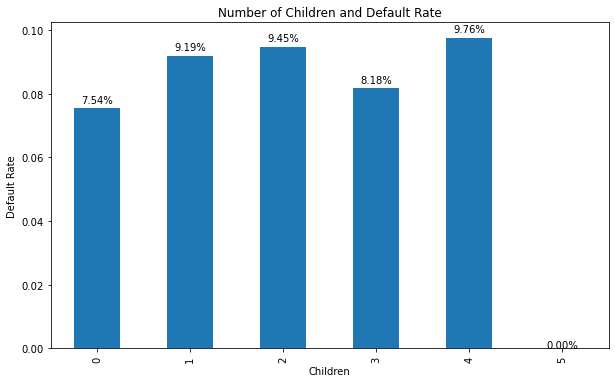

In [58]:
ax = children_default_rate['default_rate'].plot(kind='bar', figsize=(10,6))
ax.set_title('Number of Children and Default Rate')
ax.set_xlabel('Children')
ax.set_ylabel('Default Rate');

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center')

Based on the barplot, people who have 4 children are most likely to default on a loan, but people with 3 children default less than those with 1 child, so the amount of children don't really affect people's ability to repay a loan. People with 5 children never defaulted on their loan at all, this may be because there are only 9 people out of 21000+ in this dataset who have 5 children, so they may be the exceptions. 

#### Marriage and Loan Repayment

In [60]:
# categorise people's marriage status
loan_data['marriage_status'] = loan_data['family_status'] == 'married'
repayment_status_married = loan_data.groupby('marriage_status')['debt'].agg(['value_counts']).reset_index()
repayment_status_married.columns = ['marriage_status', 'default_loan', 'n_borrowers']

In [61]:
# check if there is any difference of the default rate between people who are and not married
default_rate_non_married = repayment_status_married['n_borrowers'][1] / repayment_status_married['n_borrowers'].sum()
default_rate_married = repayment_status_married['n_borrowers'][3] / repayment_status_married['n_borrowers'].sum()
print(repayment_status_married)
print()
print('The default rate for people who are not married is {:.2%}'.format(default_rate_non_married))
print('The default rate for people who are married is {:.2%}'.format(default_rate_married))

   marriage_status  default_loan  n_borrowers
0            False             0         8304
1            False             1          810
2             True             0        11408
3             True             1          931

The default rate for people who are not married is 3.78%
The default rate for people who are married is 4.34%


People who are not married have lower default rate than those who are married, although the difference is not really significant. There may be some reasons to this, e.g. those in a marriage usually have a child within the first year or two, therefore additional things may be added to their expenses; or some married couples prefer one partner to stay home while the other works their job, that decreases household income and ability to repay loan on time when there's unexpected expenses.

In [62]:
# check if specific family status affect people's default rate
marriage_default_rate = loan_data.groupby('family_status')['debt'].agg('mean').reset_index()
marriage_default_rate.columns = ['family_status', 'default_rate']
marriage_default_rate['default_rate'] = marriage_default_rate['default_rate'].astype(float)

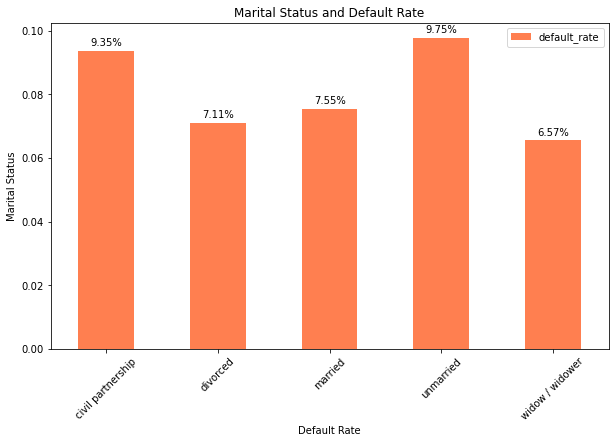

In [79]:
ax = marriage_default_rate.plot(kind='bar', x='family_status', y='default_rate', figsize=(10,6), color='coral')
ax.set_title('Marital Status and Default Rate')
ax.set_xlabel('Default Rate')
ax.set_ylabel('Marital Status')
plt.xticks(rotation=45);

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center')

After further inspection, widow/widower group have the least default rate, while people who are unmarried and on civil partnership rank highest with just a slight difference. This proves that married people are on the middle of the spectrum.

#### Income Levels and Loan Repayment

In [74]:
# categorise income into income levels 
sarray = np.sort(loan_data['total_income'])
idx = np.array_split(sarray, 3)

def income_level(income):
    if income <= idx[0].max():
        return 'low'
    elif income <= idx[1].max():
        return 'average'
    else:
        return 'high'
    
loan_data['income_group'] = loan_data['total_income'].apply(income_level)

repayment_status_income = loan_data.groupby('debt')['income_group'].agg(['value_counts']).reset_index()
repayment_status_income.columns = ['default_loan', 'income_level', 'n_borrowers']

,default_loan,income_level,n_borrowers
0,0,high,6620
1,0,low,6572
2,0,average,6520
3,1,average,632
4,1,low,580
5,1,high,529


In [75]:
# check the default rate of each income group
default_rate_high_income = repayment_status_income['n_borrowers'][5] / repayment_status_income['n_borrowers'].sum()
default_rate_avg_income = repayment_status_income['n_borrowers'][3] / repayment_status_income['n_borrowers'].sum()
default_rate_low_income = repayment_status_income['n_borrowers'][4] / repayment_status_income['n_borrowers'].sum()
print(repayment_status_income)
print()
print('The default rate for people with high income is {:.2%}'.format(default_rate_high_income))
print('The default rate for people with average income is {:.2%}'.format(default_rate_avg_income))
print('The default rate for people with low income is {:.2%}'.format(default_rate_low_income))

   default_loan income_level  n_borrowers
0             0         high         6620
1             0          low         6572
2             0      average         6520
3             1      average          632
4             1          low          580
5             1         high          529

The default rate for people with high income is 2.47%
The default rate for people with average income is 2.95%
The default rate for people with low income is 2.70%


In [87]:
income_edu = loan_data.pivot_table(
            index='income_group',
            columns='education',
            values='debt',
            aggfunc='mean')

income_edu = income_edu.fillna('0')

In [94]:
income_edu

education,income_group,bachelor's degree,graduate degree,primary education,secondary education,some college
0,average,0.062692,0,0.164557,0.096923,0.052846
1,high,0.049035,0.0,0.098361,0.085544,0.122581
2,low,0.047435,0.0,0.084507,0.086761,0.090426


In [98]:
income_job = loan_data.pivot_table(
            index='income_group',
            columns='income_type',
            values='debt',
            aggfunc='mean')

income_job.fillna('0').reset_index()

income_type,income_group,business,civil servant,employee,entrepreneur,paternity / maternity leave,retiree,student,unemployed
0,average,0.079365,0.054108,0.103682,0,0,0.054737,0,0
1,high,0.066559,0.053150,0.085723,0.0,0,0.061652,0,0.0
2,low,0.083984,0.071111,0.095925,0,1.0,0.055126,0.0,1.0


Most studies suggest that people with zero or low income are most likely to default a loan, as they have to prioritise their income to pay for essential things such as food and shelter rather than repaying debt. 

**Table 1**
By a slight margin, it turns out that people with average income has the highest default rate among three income levels. 

**Table 2**
Although the highest percentage of default rate in total is coming from people with primary education and average income, the second and third highest are from people on high income level (with primary and some college education). People with average income on other education level falls either under or pretty close to the average default rate (7.45%). To be sure, we check the default rate of each income level based on another variable. 

**Table 3**
People who are unemployed and on paternity/maternity leave stand out because they always defaulted on a loan, which makes sense considering they may earn really low salary to nothing. However, it's not being reflected on students or retiree. Employee with average income also stands out because they have the highest default rate after those with absolute default rate values.  

#### Loan Purpose and Loan Repayment

In [ ]:
# import the tools for words categorisation

english_stemmer = SnowballStemmer('english')
queries = loan_data['purpose'].unique()

In [ ]:
# check the stemmed words to group the purposes
for query in queries:
    for word in query.split(' '):
        stemmed_word = english_stemmer.stem(word)
        print(stemmed_word)

In [ ]:
# categorise the loan purpose into purpose groups
loan_data['purpose_words'] = loan_data['purpose'].str.split().apply(
    lambda x: [english_stemmer.stem(y) for y in x])
def purpose_group(purpose_words):
    if 'hous' in purpose_words or 'properti' in purpose_words or 'estat' in purpose_words:
        return 'real_estate'
    elif 'car' in purpose_words:
        return 'car'
    elif 'wed' in purpose_words:
        return 'wedding'
    elif 'educ' in purpose_words or 'univers' in purpose_words:
        return 'education'
    
loan_data['purpose_group'] = loan_data['purpose_words'].apply(purpose_group)

In [ ]:
# check if specific purpose has more significant default rate than others
purpose_default_rate = loan_data.groupby('purpose_group')['debt'].agg('mean').reset_index()
purpose_default_rate.columns = ['Purpose', 'Default Rate']
percentage = []

for row in purpose_default_rate['Default Rate']:
    row_purpose = '{:.2%}'.format(row)
    percentage.append(row_purpose)

    
purpose_default_rate['Default Rate'] = percentage
purpose_default_rate

* Even though there is not much difference, the highest default rate comes from car loans. This makes sense as car is a depreciating asset, has high maintenance cost, and very rarely producing money. 
* The second highest default rate is for education purposes, this may be due to the difficulty in obtaining a job with decent wage after finishing an education, which correlates to the point in the income level conclusion above, where people prioritise essential things for survival rather than repaying their loans.
* People who obtained loan for real estate has the lowest default rate, this may be because real estate is a high-paying asset, which can be done by renting out the property or people tend to set aside a portion of their income for paying mortgage.

### Conclusion

For data categorisation we firstly divide the dataset into categorical and quantitative data, then decide which one can be categorised in what way. The initial division is as follows:
1. Having a child and marriage status are categorical variables, therefore can be categorised simply as "people with children" and "people who don't have a child"; or "people who are married" and "people who are not married"
2. Total income is a quantitative variable, therefore categorised in a range of income levels, "low", "average" and "high".
3. Loan purpose is categorical variable, although it is harder if we categorise it in the way we do with children and marriage status. Therefore the categorisation needs to be done using word stemming and grouping the same words into groups.

## Overall Conclusion
<a name="cons"></a>

This report serves as an analysis of borrowers' credit history that will help the bank's loan department decide their credit-worthiness. Through the analysis, we have discovered relations between the variables in the borrower's  data and their ability to repay loan on time.

The analysis was done in these steps:
1. Looking at the general information in the dataset
2. Replacing missing values and artifacts
3. Processing duplicates in the dataset
4. Changing data types for ease of analysis
5. Categorising the variables to conduct the analysis

Finally, we came to the following conclusions:
* People with 1-20 kid(s) have higher default rate than average, so there is a relation between having kids and loan repayment, the more kids a borrower has, there is higher chance of defaulting on a loan.
* On the first glance, it may look like people who are married are more likely to default on a loan. But after further analysis, people who are divorced, married and widowed have pretty similar default rate on the lower end of the spectrum. While people who are unmarried and on civil partnership have similar default rate as well on the higher end. Therefore it can be concluded that there is no relation between marital status and loan repayment.
* When comparing income levels, it doesn't look like there is much difference between them. Once analysed further, it turns out that some jobs and education levels default more than others. This shows that income level on its own don't really have a relation to loan repayment, but there has to be additional variables to help with the analysis.
* Loans taken out for buying depreciating asset are more likely to be defaulted on and vice versa. But some loan purposes are not really for tangible asset, such as weddings and education, so it doesn't impact much. More variables have to be taken into account when making credit-worthiness analysis.